In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from scipy.io import loadmat
from sklearn.metrics import classification_report, multilabel_confusion_matrix, plot_confusion_matrix, plot_roc_curve, confusion_matrix, plot_precision_recall_curve
from sklearn.feature_selection import SelectFromModel
from dtreeviz.trees import dtreeviz
import time
import pandas_profiling as pp
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tools import add_constant
pd.set_option('display.max_columns', 100)


Bad key "text.kerning_factor" on line 4 in
C:\Users\cgraves\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
start_time = time.time()
raw = pd.read_csv("J:\Contact Center Reporting\Misc\Dump\SavesModelingData.csv")
print(f"Took {time.time() - start_time} seconds")

Took 27.435394763946533 seconds


In [3]:
raw.head()

,CUSTREF,POLREF,SCHEDREF,POLOPTION,POLOPTTENURE,VINTAGE,PAYTYPE,POSTCODE,SALESTYPE,PARENTID,POLICIES,CUSTTENURE,INACTIVE_POLS,FROMDATE,TODATE,CUSTCHECKDIGIT,CUSTREFCD,CUSTJOBS,POLJOBS,COMPLAINTS,SURVEYS,AVG_RATING,DISSAT_SURVEYS,SUPERCLUSTER,CLUSTER,AGE,INCOME,TTSCHED,TTCOMPLETE,REATTENDS,NCES,INACTIVEMAR1,ACTIVEMAR1
0,100001,1611995,16119951,K003,239,1,CASH,07646,POST,1,1,3526.0,1.0,NaN,NaN,6,1000016,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,65.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0
1,100002,100330,1003308,K003,72,1,ACH,07621,POST,1,1,5551.0,1.0,NaN,NaN,5,1000025,NaN,NaN,NaN,NaN,NaN,NaN,4.0,7.0,NaN,8.0,NaN,NaN,NaN,NaN,NaN,1.0
2,100010,100340,1003406,K003,72,1,ACH,07605,TELE,1,1,5551.0,1.0,NaN,NaN,5,1000105,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,88.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0
3,100010,1438117,14381178,K082,4,1,ACH,07605,TELE,1,1,5551.0,1.0,NaN,NaN,5,1000105,NaN,NaN,NaN,NaN,NaN,NaN,3.0,4.0,88.0,6.0,NaN,NaN,NaN,NaN,NaN,1.0
4,100011,1022461,10224617,K003,219,1,CC,07666,POST,1,1,3871.0,1.0,NaN,NaN,4,1000114,NaN,NaN,NaN,NaN,NaN,NaN,7.0,28.0,94.0,2.0,NaN,NaN,NaN,NaN,NaN,1.0


In [4]:
raw.shape

(6992182, 33)

In [5]:
sample = raw.sample(100000)

In [6]:
agemean = raw['AGE'].mean()
incmean = raw['INCOME'].mean()
ttsmean = raw['TTSCHED'].mean()
ttcmean = raw['TTCOMPLETE'].mean()

In [7]:
start_time = time.time()
raw['EVERJOB'] = 0
raw.loc[~raw['TTCOMPLETE'].isna(), 'EVERJOB'] = 1
raw = raw.fillna({'INACTIVE_POLS': 0, 'CUSTJOBS': 0, 'POLJOBS': 0, 'COMPLAINTS': 0, 'SURVEYS': 0,
                  'DISSAT_SURVEYS': 0, 'SUPERCLUSTER': 0, 'CLUSTER': 0, 'REATTENDS': 0, 'NCES': 0,
                  'ACTIVEMAR1': 0, 'INACTIVEMAR1': 0, 'AGE': agemean, 'INCOME': incmean, 'TTSCHED': ttsmean,
                  'TTCOMPLETE': ttcmean,
                                   'AVG_RATING': 5})
# raw = raw.drop(['OOP'], axis = 1)
print(f"Took {time.time() - start_time} seconds")

Took 3.7118494510650635 seconds


In [8]:
#create salestype categories
raw['SALESTYPE2'] = "OTHER"
raw.loc[(raw['SALESTYPE'] == 'POST'), 'SALESTYPE2'] = "POST"
raw.loc[(raw['SALESTYPE'] == 'TELE'), 'SALESTYPE2'] = "TELE"
raw.loc[(raw['SALESTYPE'] == 'FILE'), 'SALESTYPE2'] = "FILE"
raw.loc[(raw['SALESTYPE'] == 'WEBREALTIME'), 'SALESTYPE2'] = "WEB"
raw.loc[(raw['SALESTYPE'] == 'STS'), 'SALESTYPE2'] = "STS"
raw.loc[(raw['SALESTYPE'] == 'WEB'), 'SALESTYPE2'] = "WEB"
raw.loc[(raw['SALESTYPE'] == 'WEBBATCH'), 'SALESTYPE2'] = "WEB"

raw['SALESTYPE2'].value_counts()

POST     3443146
TELE     1584428
FILE     1152305
WEB       506522
STS       295454
OTHER      10327
Name: SALESTYPE2, dtype: int64

In [9]:
rawNoNA = raw.drop(['FROMDATE', 'TODATE'], axis=1)
rawNoNA = rawNoNA[~rawNoNA.isna().any(axis=1)].reset_index()


In [10]:
start_time = time.time()

# rawNoNA['INACTIVE_POLS%'] = [row['INACTIVE_POLS'] / row['CUSTJOBS'] if row['CUSTJOBS'] > 0 else 0 for row in rawNoNA]
rawNoNA['INACTIVE_POLS%'] = rawNoNA.apply(lambda row: row['INACTIVE_POLS'] / row['CUSTJOBS'] if row['CUSTJOBS'] > 0 else 0, axis= 1)
# rawNoNA['DISSAT_SURVEY%'] = [row['DISSAT_SURVEYS'] / row['SURVEYS'] if row['SURVEYS'] > 0 else 0 for row in rawNoNA]
rawNoNA['DISSAT_SURVEY%'] = rawNoNA.apply(lambda row: row['DISSAT_SURVEYS'] / row['SURVEYS'] if row['SURVEYS'] > 0 else 0, axis= 1)
# rawNoNA['REATTEND%'] = [row['REATTENDS'] / row['CUSTJOBS'] if row['CUSTJOBS'] > 0 else 0 for row in rawNoNA]
rawNoNA['REATTEND%'] = rawNoNA.apply(lambda row: row['REATTENDS'] / row['CUSTJOBS'] if row['CUSTJOBS'] > 0 else 0, axis= 1)
# rawNoNA['ACTIVITY'] = [(row['SURVEYS'] + row['CUSTJOBS'] + row['NCEs']) / row['CUSTTENURE'] 
#                        if row['CUSTTENURE'] > 0 else 0 for row in rawNoNA]
rawNoNA['ACTIVITY'] = rawNoNA.apply(lambda row: (row['SURVEYS'] + row['CUSTJOBS'] + row['NCES']) / row['CUSTTENURE'] 
                       if row['CUSTTENURE'] > 0 else 0, axis= 1)

rawNoNA = rawNoNA.drop(['REATTENDS', 'INACTIVE_POLS', 'DISSAT_SURVEYS'], axis = 1)

### Uncommenting the below makes this analysis look only at customers with recent jobs.

rawNoNA = rawNoNA.loc[rawNoNA['EVERJOB'] == 1]

print(f"Took {time.time() - start_time} seconds")

Took 400.2953071594238 seconds


In [11]:
###one-hot encode paytype, sales type, and supercluster
salesdummies = pd.get_dummies(rawNoNA.SALESTYPE2, prefix="SALETYPE")
salesdummies = salesdummies.drop(['SALETYPE_OTHER', 'SALETYPE_WEB'], axis = 1)
# salesdummies.head()

paytypedummies = pd.get_dummies(rawNoNA.PAYTYPE, prefix="PAYTYPE")
paytypedummies = paytypedummies.drop(['PAYTYPE_WAR', 'PAYTYPE_PAPER', 'PAYTYPE_CASH'], axis = 1)
# paytypedummies.head()

# superclusterdummies = pd.get_dummies(raw.SUPERCLUSTER, prefix="SC")

# Activity ratio: surveys + jobs + nces / cust tenure
# Inactive % = inactive pols / pols
# dissat % = dissat surv / surveys
# reattend ratio = reattends / jobs
# nce ratio = nces / jobs
# ever job: 1 if ttcomp is not nan

In [12]:
# drop irrelevant columns -- no POSTCODE for now
start = time.time()

### COlumns dropped from original dataset: vintage, poljobs, reattend, dissatsurv, inactivepols
clean = rawNoNA[['CUSTTENURE', 'POLOPTTENURE', 'POLICIES', 
       'INACTIVE_POLS%', 'CUSTJOBS', 'POLJOBS',
       'COMPLAINTS', 'SURVEYS', 'AVG_RATING', 'DISSAT_SURVEY%', 'SUPERCLUSTER',
       'AGE', 'INCOME', 'TTSCHED', 'TTCOMPLETE', 'REATTEND%',
       'NCES', 'ACTIVITY', 'EVERJOB']]
# clean = clean.dropna()

labels = rawNoNA[['INACTIVEMAR1']]
labels2 = rawNoNA[['ACTIVEMAR1']]

fulldata = pd.concat([clean, salesdummies, paytypedummies], axis = 1)
# fulldata = fulldata.drop(['PAYTYPE_WAR', 'PAYTYPE_PAPER', 'PAYTYPE_CASH', 'SALETYPE_OTHER', 'SALETYPE_WEB'], axis = 1)


print(f"Took {time.time() - start} seconds")

Took 1.9181914329528809 seconds


In [13]:
fulldata.head()

,CUSTTENURE,POLOPTTENURE,POLICIES,INACTIVE_POLS%,CUSTJOBS,POLJOBS,COMPLAINTS,SURVEYS,AVG_RATING,DISSAT_SURVEY%,SUPERCLUSTER,AGE,INCOME,TTSCHED,TTCOMPLETE,REATTEND%,NCES,ACTIVITY,EVERJOB,SALETYPE_FILE,SALETYPE_POST,SALETYPE_STS,SALETYPE_TELE,PAYTYPE_ACH,PAYTYPE_CC,PAYTYPE_INV
0,3526.0,239,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,65.000000,6.0,0.4634,4.602818,0.0,0.0,0.0,0,0,1,0,0,0,0,0
1,5551.0,72,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,63.508998,8.0,0.4634,4.602818,0.0,0.0,0.0,0,0,1,0,0,1,0,0
2,5551.0,72,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,88.000000,6.0,0.4634,4.602818,0.0,0.0,0.0,0,0,0,0,1,1,0,0
3,5551.0,4,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,3.0,88.000000,6.0,0.4634,4.602818,0.0,0.0,0.0,0,0,0,0,1,1,0,0
4,3871.0,219,1,0.0,0.0,0.0,0.0,0.0,5.0,0.0,7.0,94.000000,2.0,0.4634,4.602818,0.0,0.0,0.0,0,0,1,0,0,0,1,0


In [14]:
fulldatalabs = pd.concat([fulldata, labels], axis=1)

# vizdata = pd.concat([fulldata.iloc[:,0:18], labels], axis = 1).sample(1000)
vizdata = pd.concat([fulldata.iloc[:,0:18], labels], axis = 1).groupby('INACTIVEMAR1', group_keys=False).apply(lambda x: x.sample(500))

# Exploratory Visualizations

C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Took 67.01059699058533 seconds


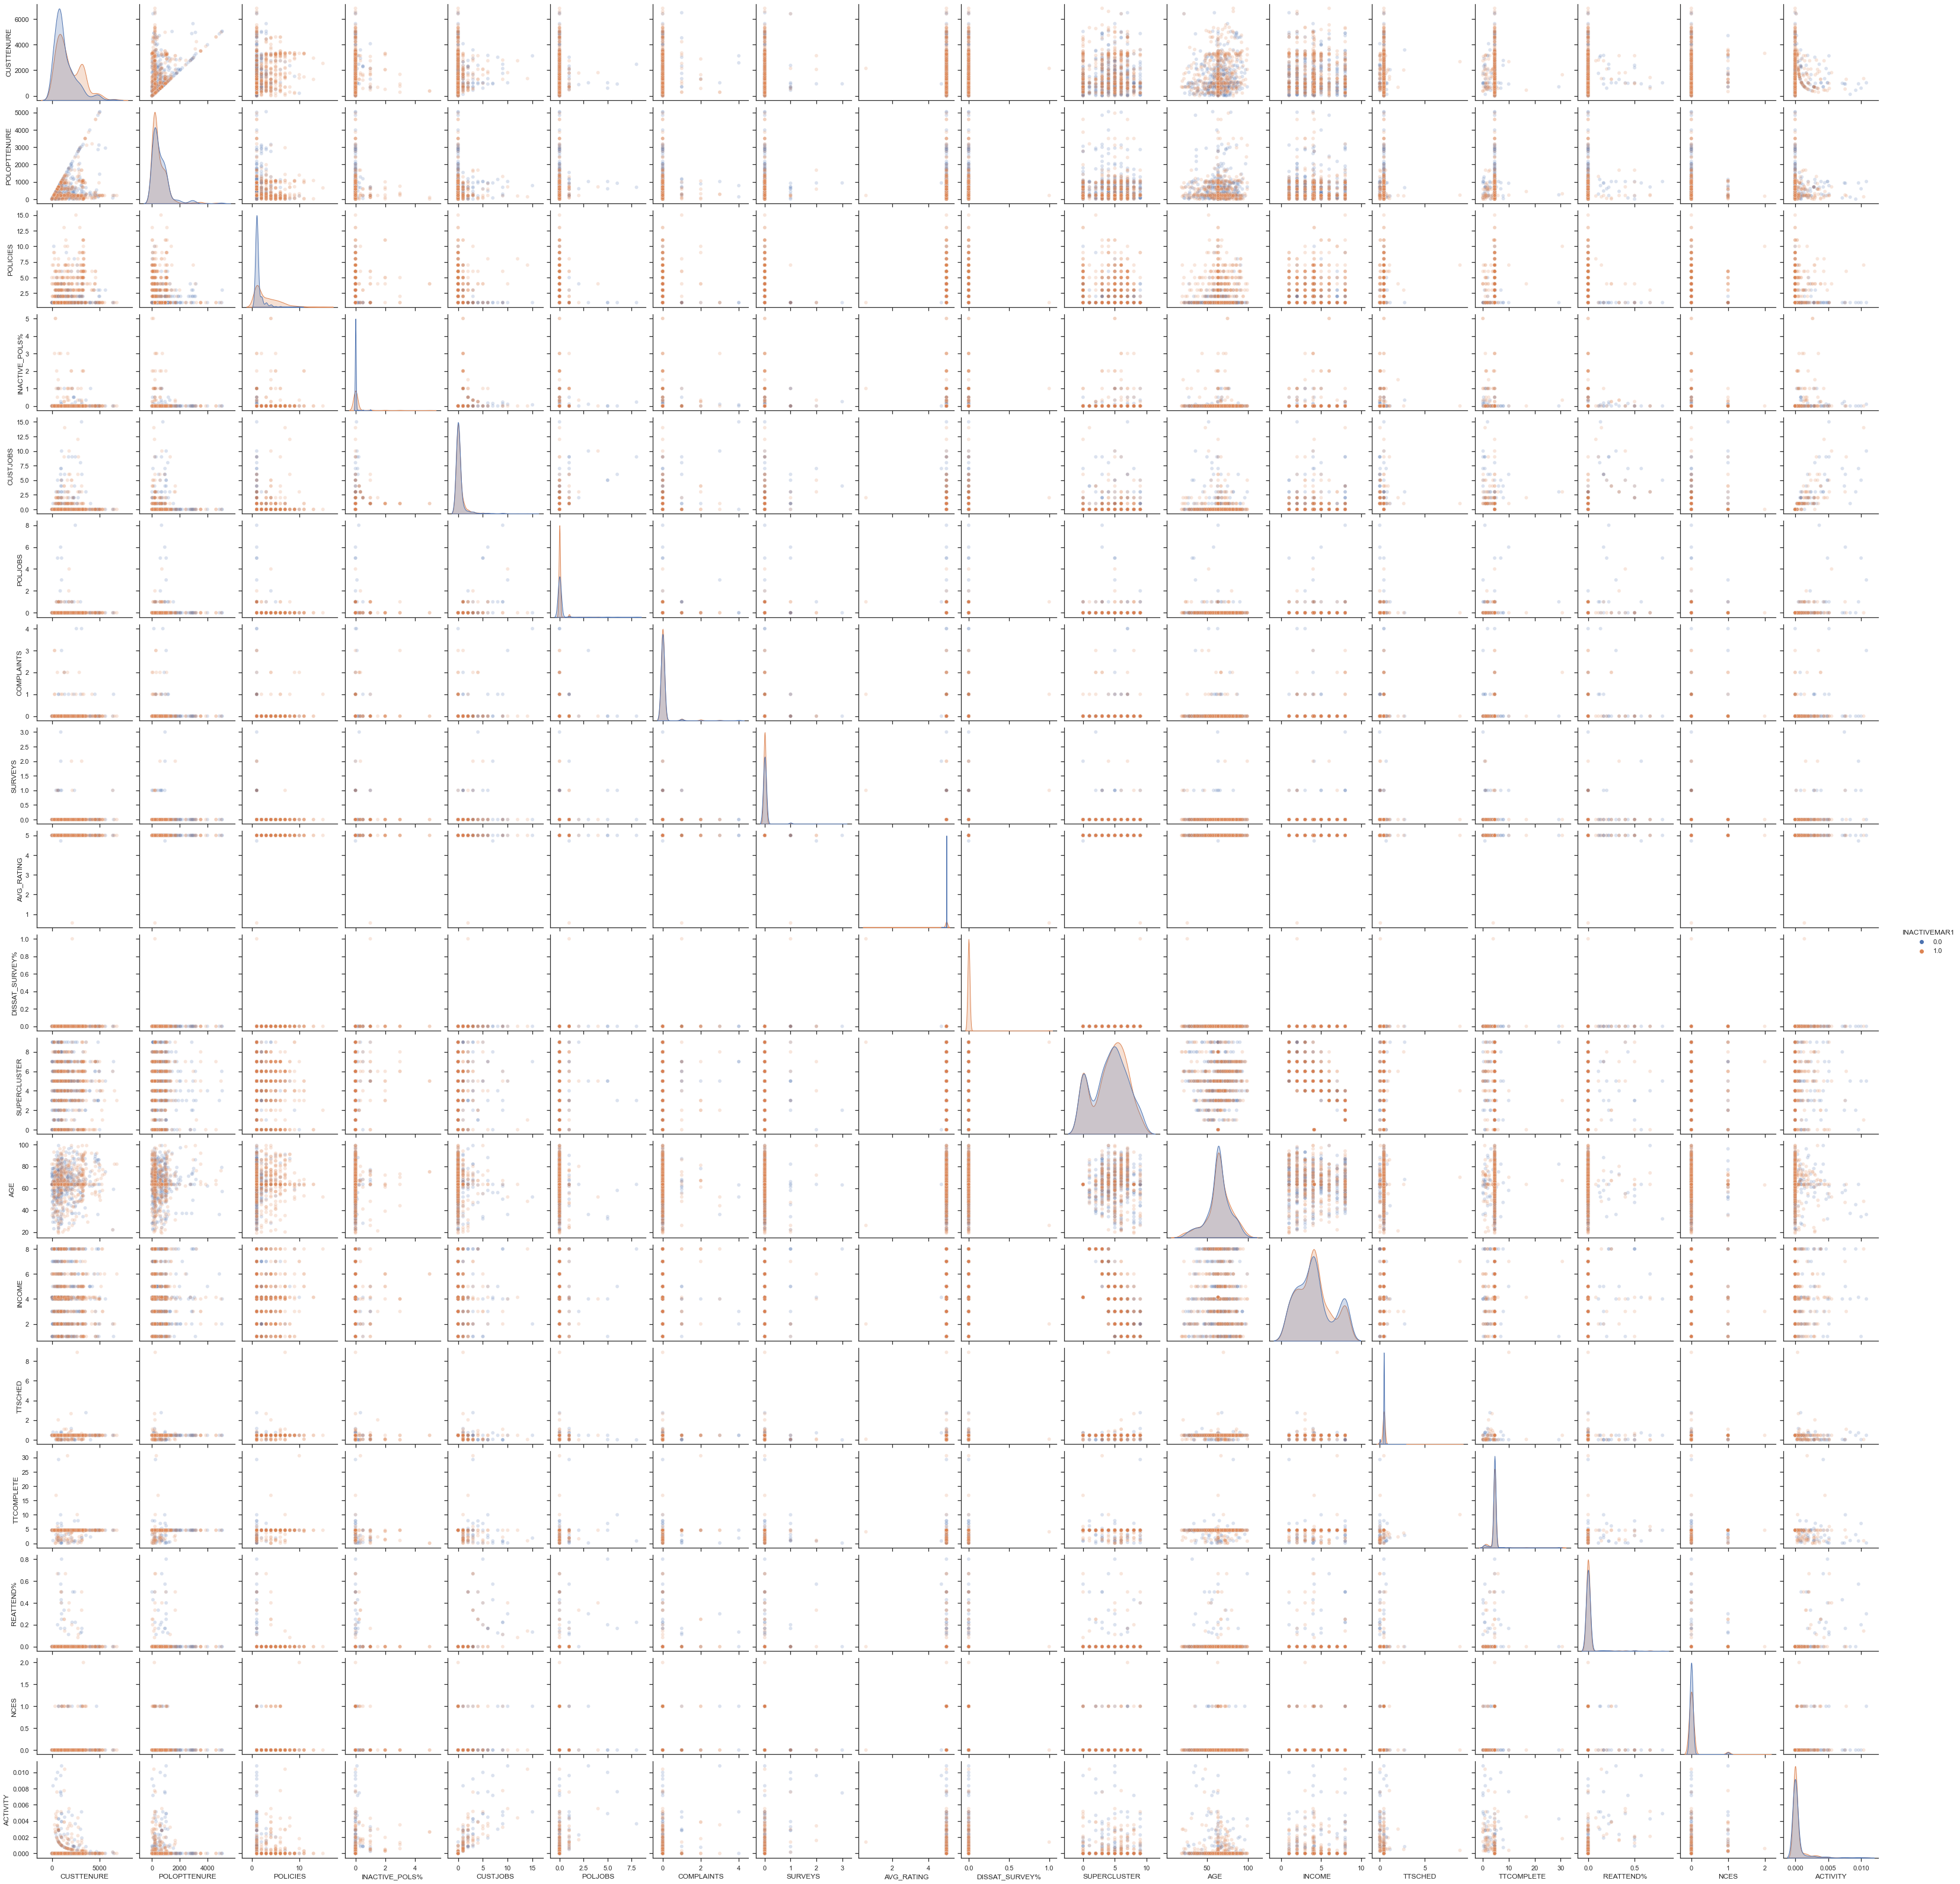

In [15]:
start = time.time()

sns.set_theme(style="ticks")

sns.pairplot(vizdata, hue="INACTIVEMAR1", plot_kws={'alpha':0.2})

print(f"Took {time.time() - start} seconds")

<AxesSubplot:>

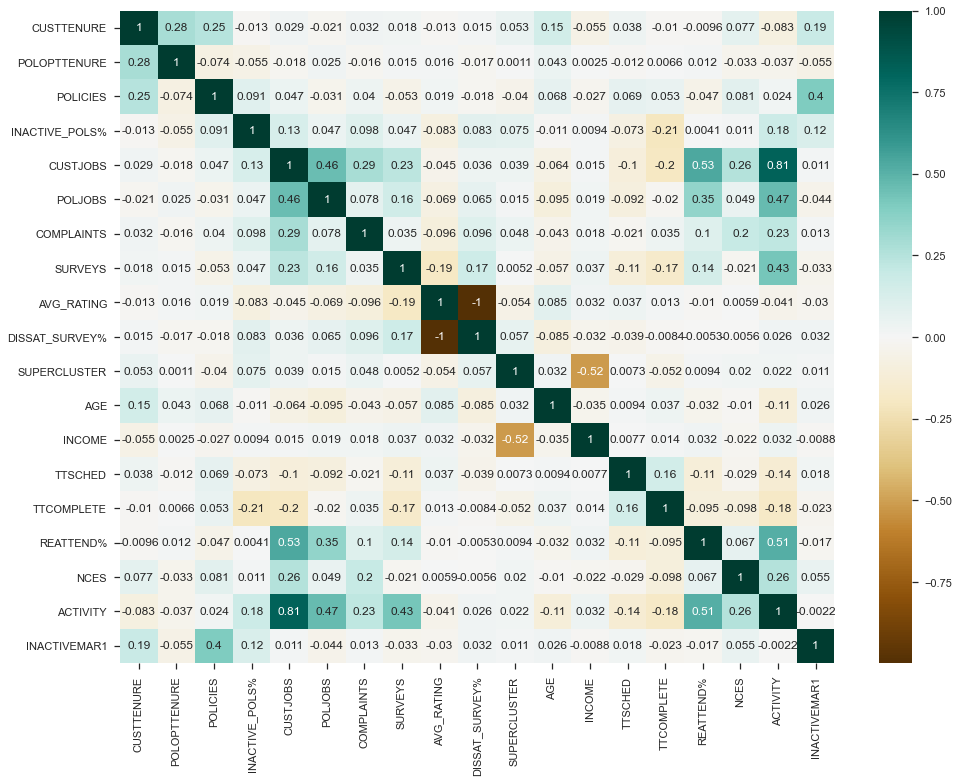

In [16]:
corrs = vizdata.corr()
plt.figure(figsize = (16,12))
sns.heatmap(corrs, annot=True, cmap="BrBG")

start_time = time.time()
profile = pp.ProfileReport(fulldatalabs, minimal=True)
profile.to_file(output_file="EDAfull.html")
print(f"Took {time.time() - start_time} seconds")

## Split and Normalize

In [17]:
start = time.time()

xtrain, xtest, ytrain, ytest = train_test_split(fulldata, labels, test_size = .2,
                                                random_state = 11, stratify = labels)
# xtrain = np.array(xtrain)
# ytrain = np.array(ytrain)
# xtest = np.array(xtest)
# ytest = np.array(ytest)
print(type(xtrain))


print(f"Took {time.time() - start} seconds")

<class 'pandas.core.frame.DataFrame'>
Took 38.239707708358765 seconds


In [18]:

# labels = data.iloc[:,-1:]
# data = data.iloc[:,:54]
# data.head()
# data = np.array(data)
# labels = np.array(labels)
start = time.time()

scaler = StandardScaler() #with_mean = False)

# cleanscaled = scaler.fit_transform(clean)
# fullscaled = pd.concat([pd.DataFrame(cleanscaled), salesdummies, paytypedummies], axis = 1)
#print(fullscaled[:5])

xtraincats = xtrain.loc[:,'EVERJOB':].reset_index().drop(columns = ['index'])
xtestcats = xtest.loc[:,'EVERJOB':].reset_index().drop(columns = ['index'])
xtrainscale = pd.DataFrame(scaler.fit_transform(xtrain.loc[:,'CUSTTENURE':'ACTIVITY']), columns = xtrain.columns[:18])
xtestscale = pd.DataFrame(scaler.transform(xtest.loc[:,'CUSTTENURE':'ACTIVITY']), columns = xtest.columns[:18])

xtrainpd = pd.concat([xtrainscale, xtraincats], axis = 1)
xtestpd = pd.concat([xtestscale, xtestcats], axis = 1)

xtrain = np.array(xtrainpd)
ytrain = np.array(ytrain)
xtest = np.array(xtestpd)
ytest = np.array(ytest)

# xtrainlabs = pd.DataFrame(xtrain)
# xtrainlabs.columns = fulldata.columns.tolist()
xtrainlabs = xtrainpd[~np.isnan(xtrainpd).any(axis=1)]

print(f"Took {time.time() - start} seconds")

Took 15.658693313598633 seconds


# Full Data Models

## Logistic Regression

In [19]:
start = time.time()

start = time.time()
logmodel = LogisticRegression(max_iter = 2000)
logmodel.fit(xtrain, ytrain.ravel())
ypred = logmodel.predict(xtest)
print(f"Logistic Regression score: {logmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Logistic Regression score: 0.9985605347688418
Took 95.73233675956726 seconds


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 6.632116794586182 seconds


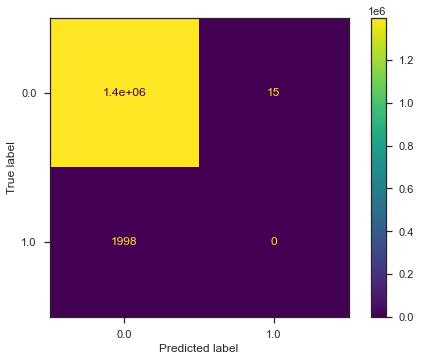

In [20]:
start = time.time()

print(plot_confusion_matrix(logmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 0.7871251106262207 seconds


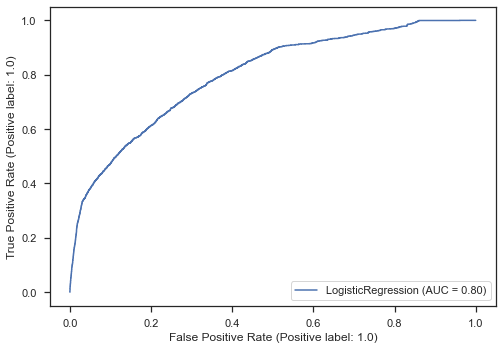

In [21]:
start = time.time()

plot_roc_curve(logmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 1.697141170501709 seconds


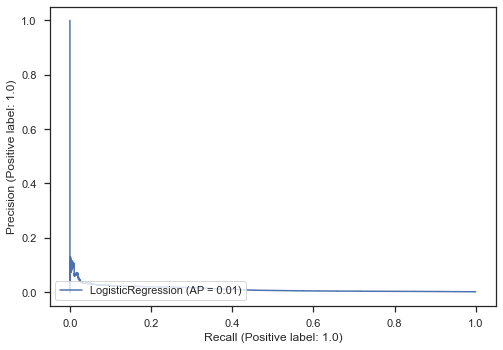

In [91]:
start = time.time()

plot_precision_recall_curve(logmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

In [22]:
start = time.time()

logmodel2 = sm.Logit(ytrain, xtrainlabs).fit_regularized()
print(logmodel2.summary())

print(f"Took {time.time() - start} seconds")

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.011430607749411688
            Iterations: 264
            Function evaluations: 279
            Gradient evaluations: 264
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:              5593740
Model:                          Logit   Df Residuals:                  5593714
Method:                           MLE   Df Model:                           25
Date:                Sun, 02 May 2021   Pseudo R-squ.:                -0.05975
Time:                        14:28:04   Log-Likelihood:                -63940.
converged:                       True   LL-Null:                       -60335.
Covariance Type:            nonrobust   LLR p-value:                     1.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

AxesSubplot(0.125,0.125;0.62x0.755)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.05      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.52      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 7.9623188972473145 seconds


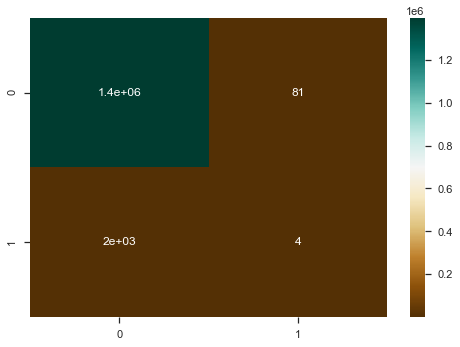

In [23]:
start = time.time()

ypred = logmodel2.predict(xtest)
ypred = list(map(round, ypred))
print(sns.heatmap(confusion_matrix(ytest, ypred), annot=True, cmap="BrBG"))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

In [86]:
start = time.time()

start = time.time()

features = SelectFromModel(rfmodel, prefit=True)
xtrain_new = features.transform(xtrain)
xtest_new = features.transform(xtest)
logmodel3 = LogisticRegression(C=0.1, max_iter = 2000)
logmodel3.fit(xtrain_new, ytrain.ravel())
ypred = logmodel3.predict(xtest_new)
print(f"Logistic Regression score: {logmodel3.score(xtest_new, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Logistic Regression score: 0.9985669705299348
Took 17.714403867721558 seconds


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 6.573516368865967 seconds


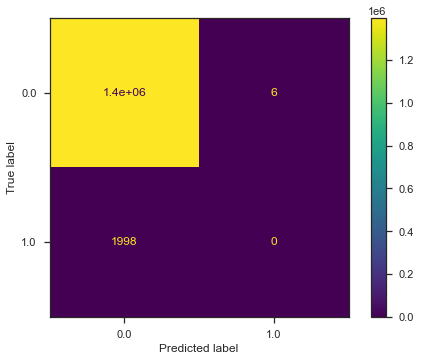

In [87]:
start = time.time()

print(plot_confusion_matrix(logmodel3, xtest_new, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 0.7510545253753662 seconds


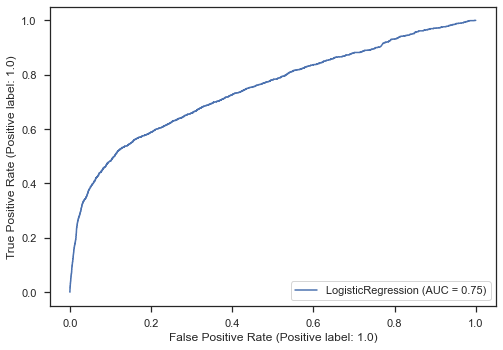

In [88]:
start = time.time()

plot_roc_curve(logmodel3, xtest_new, ytest)

print(f"Took {time.time() - start} seconds")

Took 1.6161246299743652 seconds


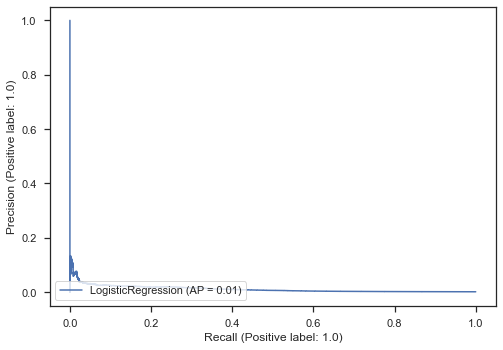

In [92]:
start = time.time()

plot_precision_recall_curve(logmodel3, xtest_new, ytest)

print(f"Took {time.time() - start} seconds")

## Naive Bayes

In [24]:
start = time.time()

nbmodel = GaussianNB(var_smoothing = 1e-3)
nbmodel.fit(xtrain, ytrain.ravel())
ypred = logmodel.predict(xtest)
print(f"Naive Bayes score: {nbmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Naive Bayes score: 0.946028277304074
Took 9.554568767547607 seconds


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 8.163336038589478 seconds


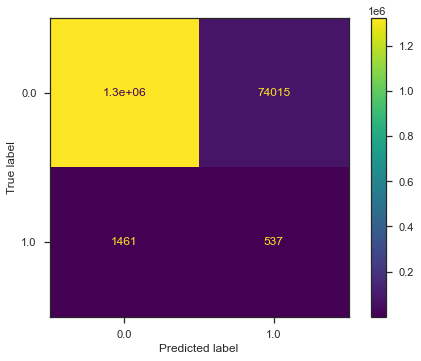

In [25]:
start = time.time()

print(plot_confusion_matrix(nbmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 2.650458574295044 seconds


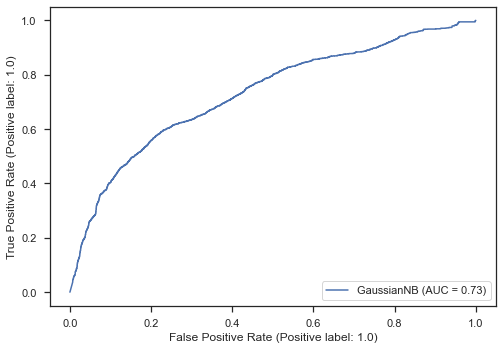

In [26]:
start = time.time()

plot_roc_curve(nbmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 3.642282485961914 seconds


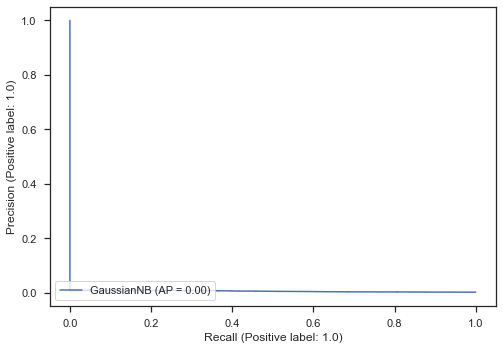

In [94]:
start = time.time()

plot_precision_recall_curve(nbmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

## Neural Net

In [27]:
start = time.time()

nnmodel = MLPClassifier(hidden_layer_sizes = (20, 10), max_iter = 2000)
nnmodel.fit(xtrain, ytrain.ravel())
ypred = nnmodel.predict(xtest)
print(f"Neural Network score: {nnmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Neural Network score: 0.9985712610373303
Took 465.8448884487152 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 8.09229564666748 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


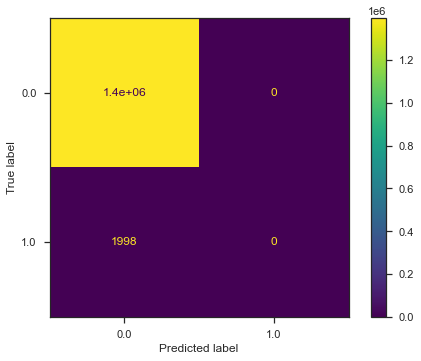

In [28]:
start = time.time()

print(plot_confusion_matrix(nnmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 2.309366464614868 seconds


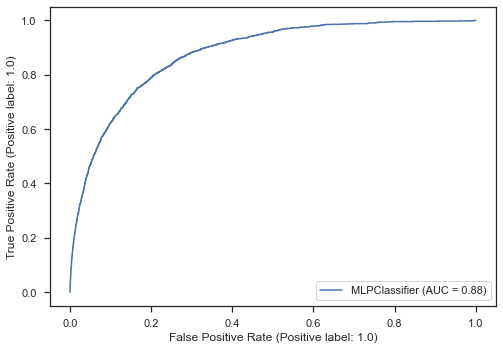

In [29]:
start = time.time()

plot_roc_curve(nnmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 3.245251178741455 seconds


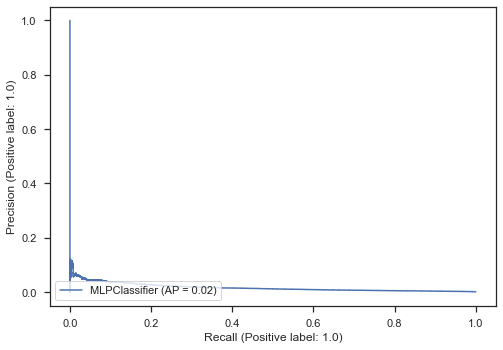

In [95]:
start = time.time()

plot_precision_recall_curve(nnmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

## Decision Tree and Random Forest

In [53]:
start = time.time()

dtmodel = DecisionTreeClassifier(max_depth = 5, min_samples_leaf = 10, max_leaf_nodes = 200)
dtmodel.fit(xtrain, ytrain.ravel())
ypred = dtmodel.predict(xtest)
print(f"Decision Tree score: {dtmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Decision Tree score: 0.9985712610373303
Took 63.75410342216492 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 7.486714839935303 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


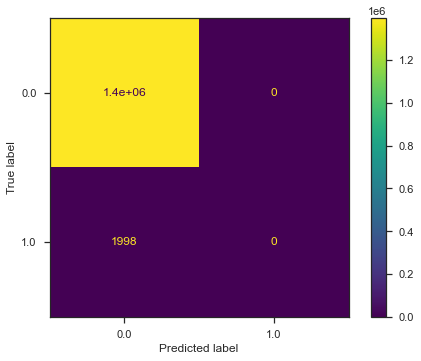

In [54]:
start = time.time()

print(plot_confusion_matrix(dtmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 0.6720671653747559 seconds


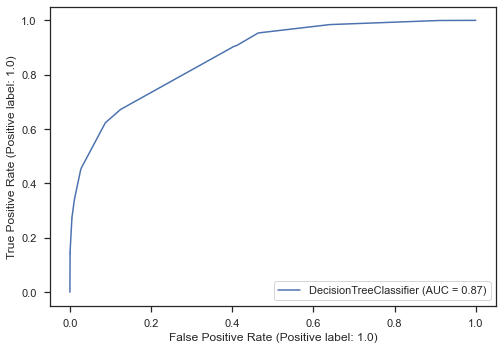

In [55]:
start = time.time()

plot_roc_curve(dtmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 1.2130918502807617 seconds


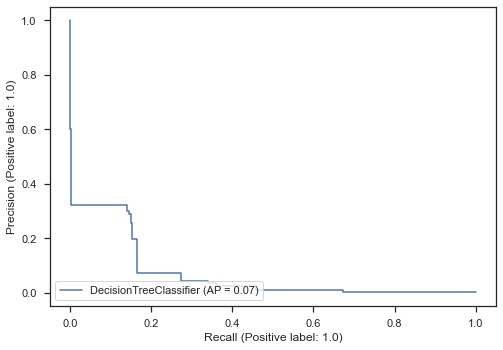

In [96]:
start = time.time()

plot_precision_recall_curve(dtmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

In [56]:
start = time.time()


# plt.figure(figsize=(20,10))
# plot_tree(dtmodel)
# plt.figure().savefig('DTreeImg.png', dpi=800)
# plt.show()
# viz = dtreeviz(dtmodel, xtest, ytest, target_name = 'INACIVEMAR1', feature_names = fulldatalabs.columns, 
#               class_names = ['cancelled', 'active'])
# viz.view()
print(export_text(dtmodel, feature_names = fulldata.columns.tolist(), show_weights = True))

print(f"Took {time.time() - start} seconds")

|--- POLICIES <= 2.97
|   |--- POLICIES <= 1.06
|   |   |--- PAYTYPE_INV <= 0.50
|   |   |   |--- POLOPTTENURE <= -0.60
|   |   |   |   |--- SALETYPE_FILE <= 0.50
|   |   |   |   |   |--- weights: [503706.00, 4.00] class: 0.0
|   |   |   |   |--- SALETYPE_FILE >  0.50
|   |   |   |   |   |--- weights: [13719.00, 4.00] class: 0.0
|   |   |   |--- POLOPTTENURE >  -0.60
|   |   |   |   |--- POLOPTTENURE <= -0.59
|   |   |   |   |   |--- weights: [2188.00, 1188.00] class: 0.0
|   |   |   |   |--- POLOPTTENURE >  -0.59
|   |   |   |   |   |--- weights: [1552077.00, 1752.00] class: 0.0
|   |   |--- PAYTYPE_INV >  0.50
|   |   |   |--- POLICIES <= 0.10
|   |   |   |   |--- POLOPTTENURE <= 0.03
|   |   |   |   |   |--- weights: [1502301.00, 139.00] class: 0.0
|   |   |   |   |--- POLOPTTENURE >  0.03
|   |   |   |   |   |--- weights: [979331.00, 262.00] class: 0.0
|   |   |   |--- POLICIES >  0.10
|   |   |   |   |--- POLOPTTENURE <= -0.35
|   |   |   |   |   |--- weights: [209217.00, 440.00] 

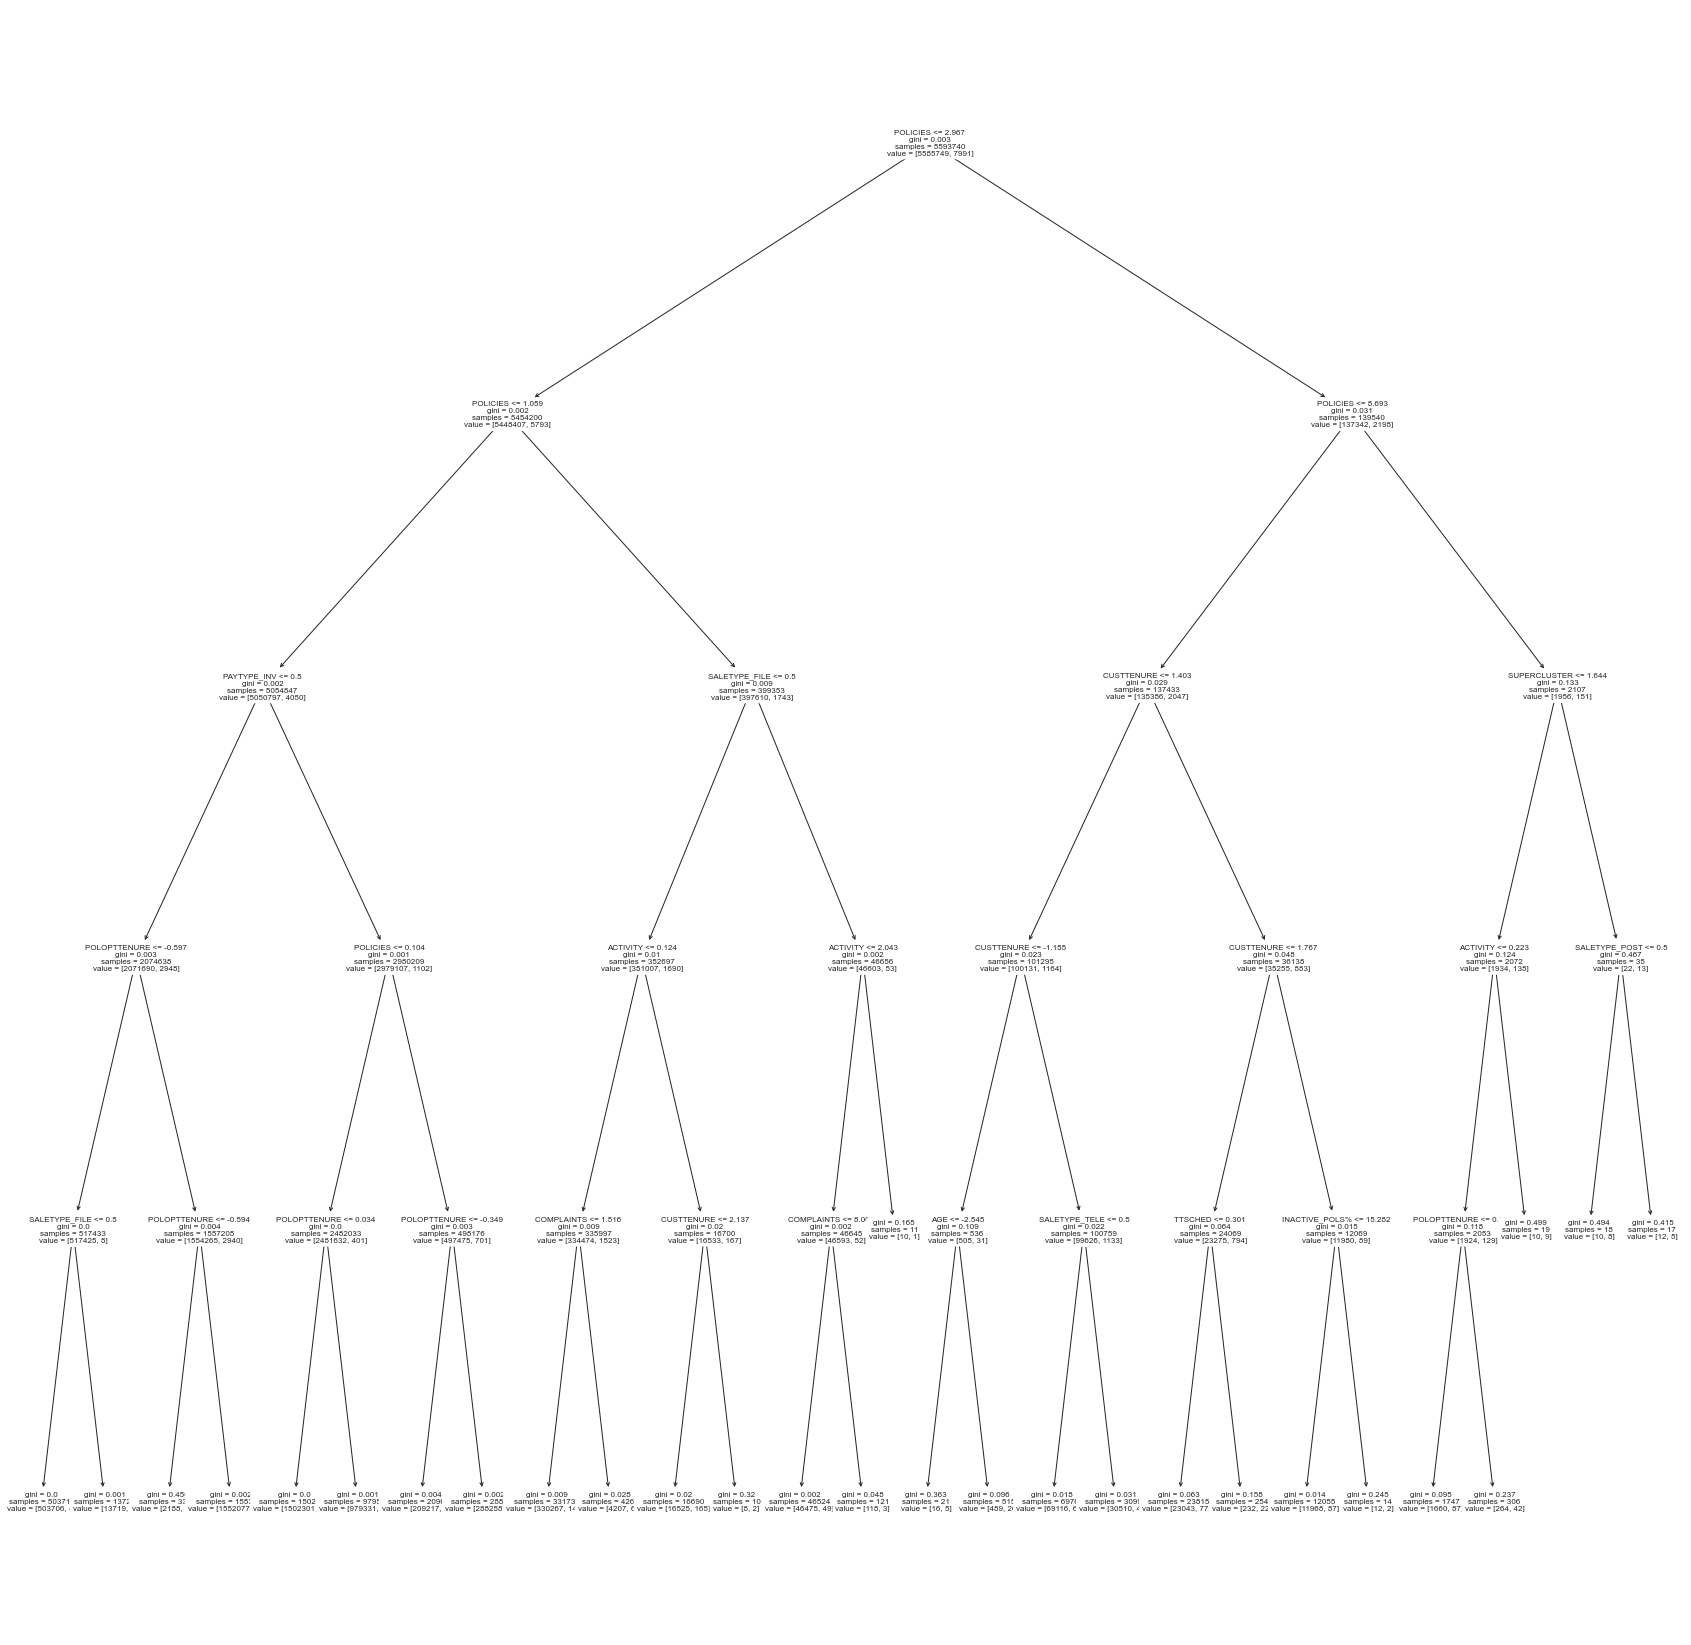

In [74]:
plt.figure(figsize=(30,30))
plot_tree(dtmodel, fontsize = 8, rounded = True, feature_names = fulldata.columns.tolist())
# plt.show()
plt.savefig('DTreeImg.png', bbox_inches = "tight", dpi=300)
# plt.show()

# viz = dtreeviz(dtmodel, xtest, ytest, target_name = 'INACIVEMAR1', feature_names = fulldatalabs.columns)
# viz.view()

In [105]:
start = time.time()

rfmodel = RandomForestClassifier(max_depth=20, n_estimators=200, max_features=1)
rfmodel.fit(xtrain, ytrain.ravel())
ypred = rfmodel.predict(xtest)
print(f"Random Forest score: {rfmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Random Forest score: 0.9985827023903847
Took 3951.353744029999 seconds


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.68      0.02      0.03      1998

    accuracy                           1.00   1398436
   macro avg       0.84      0.51      0.51   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 83.1031904220581 seconds


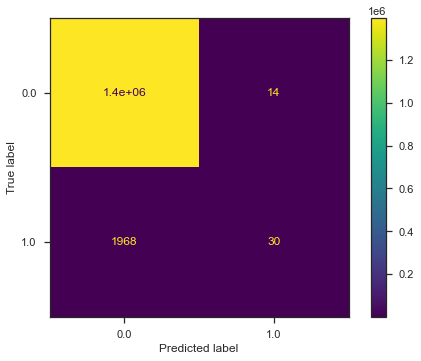

In [106]:
start = time.time()

print(plot_confusion_matrix(rfmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 75.18407940864563 seconds


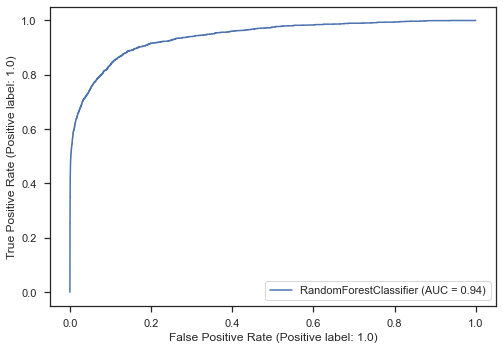

In [107]:
start = time.time()

plot_roc_curve(rfmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 75.69015383720398 seconds


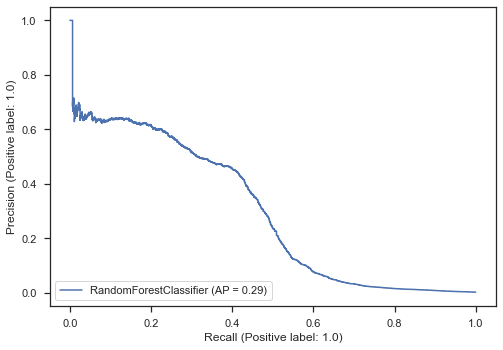

In [108]:
start = time.time()

plot_precision_recall_curve(rfmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

In [77]:
start = time.time()

print(rfmodel.feature_importances_)

print(f"Took {time.time() - start} seconds")

[0.16724887 0.2909223  0.08089029 0.01766853 0.01936394 0.01945186
 0.0129593  0.00508915 0.00298278 0.00074788 0.04440475 0.08570801
 0.03855949 0.0429053  0.03928103 0.00957168 0.0078093  0.06674652
 0.00328512 0.00447207 0.00780548 0.00157377 0.0081518  0.00561408
 0.00640796 0.01037872]
Took 0.014999151229858398 seconds


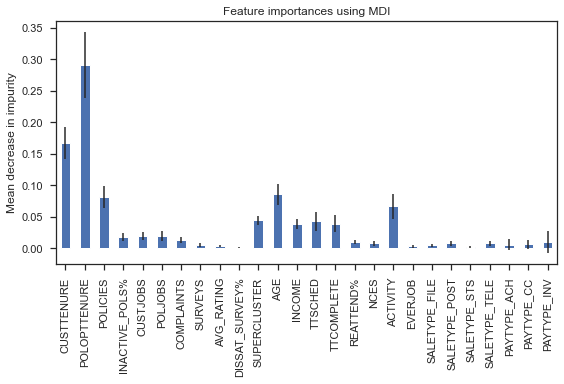

In [82]:
##FEATURE IMPORTANCE:
start_time = time.time()
importances = rfmodel.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rfmodel.estimators_], axis=0)
elapsed_time = time.time() - start_time

forest_importances = pd.Series(importances, index=fulldata.columns.tolist())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Boosted Models

In [37]:
start = time.time()

boostmodel = AdaBoostClassifier()
boostmodel.fit(xtrain, ytrain.ravel())
ypred = boostmodel.predict(xtest)
print(f"Ada Boost score: {boostmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Ada Boost score: 0.9985712610373303
Took 971.9517457485199 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.00      0.00      0.00      1998

    accuracy                           1.00   1398436
   macro avg       0.50      0.50      0.50   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 31.218286752700806 seconds


C:\Users\cgraves\Anaconda3\envs\saves\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


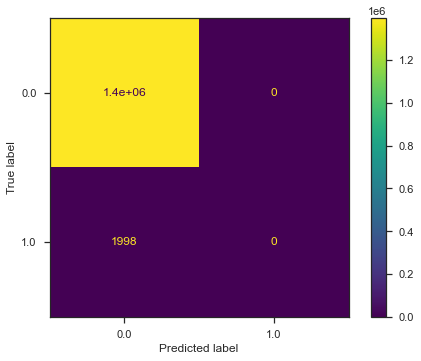

In [38]:
start = time.time()

print(plot_confusion_matrix(boostmodel, xtest, ytest))
print(classification_report(ytest, ypred))

print(f"Took {time.time() - start} seconds")

Took 25.218459129333496 seconds


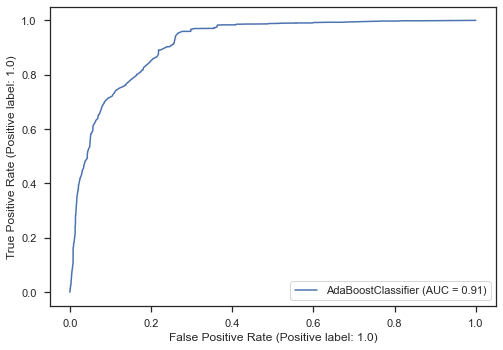

In [39]:
start = time.time()

plot_roc_curve(boostmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 25.564988613128662 seconds


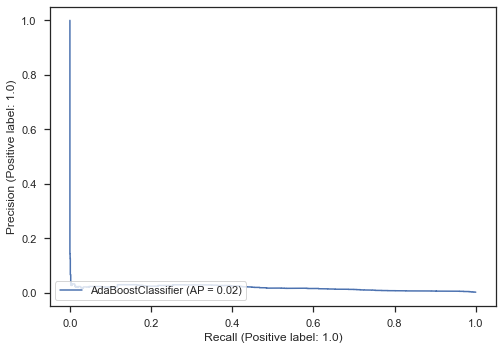

In [98]:
start = time.time()

plot_precision_recall_curve(boostmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

In [40]:
start = time.time()

gboostmodel = GradientBoostingClassifier()
gboostmodel.fit(xtrain, ytrain.ravel())
ypred = gboostmodel.predict_proba(xtest)
print(f"Gradient Boost score: {gboostmodel.score(xtest, ytest.ravel())}")

print(f"Took {time.time() - start} seconds")

Gradient Boost score: 0.9972512149286775
Took 2881.120341539383 seconds


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   1396438
         1.0       0.12      0.15      0.13      1998

    accuracy                           1.00   1398436
   macro avg       0.56      0.57      0.57   1398436
weighted avg       1.00      1.00      1.00   1398436

Took 16.555907011032104 seconds


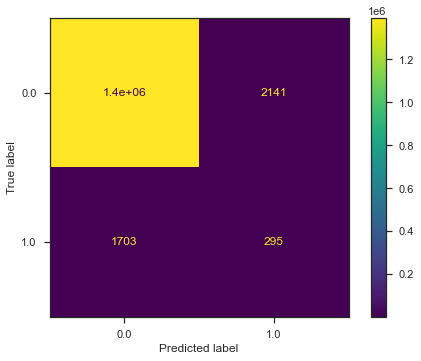

In [41]:
start = time.time()

for x in [.5]:
#     ypred2 = np.where(ypred > x, 1.0, 0.0)
    ypred2 = gboostmodel.predict(xtest)
    print(plot_confusion_matrix(gboostmodel, xtest, ytest))
    print(classification_report(ytest, ypred2))
#     print(sns.heatmap(np.concatenate((ypred2, ytest), axis= 1), annot=True, cmap="BrBG"))

print(f"Took {time.time() - start} seconds")

Took 5.394619464874268 seconds


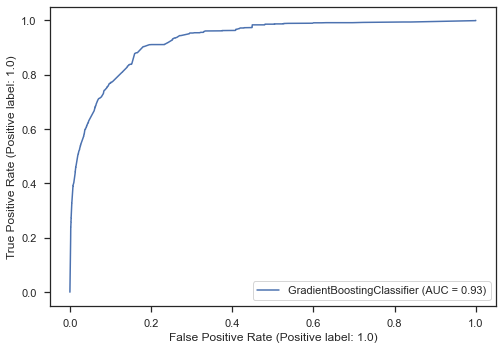

In [42]:
start = time.time()

plot_roc_curve(gboostmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

Took 6.202479362487793 seconds


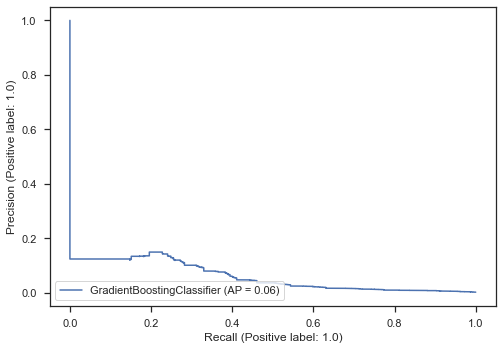

In [99]:
start = time.time()

plot_precision_recall_curve(gboostmodel, xtest, ytest)

print(f"Took {time.time() - start} seconds")

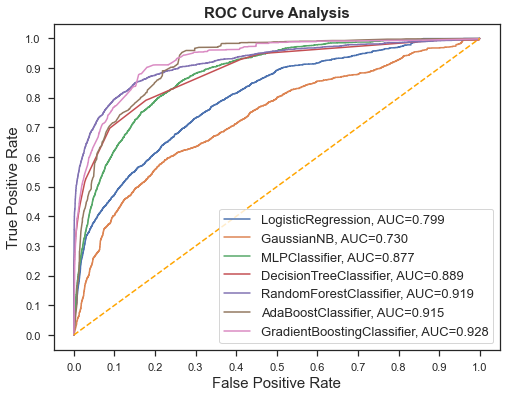

Took 53.43837285041809 seconds


In [52]:
### MAKING CHART FOR PAPER
start = time.time()

from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [logmodel, nbmodel, nnmodel, dtmodel, rfmodel, boostmodel, gboostmodel]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for model in classifiers:
    yproba = model.predict_proba(xtest)[::,1]
    
    fpr, tpr, _ = roc_curve(ytest,  yproba)
    auc = roc_auc_score(ytest, yproba)
    
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
# Plot the figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

print(f"Took {time.time() - start} seconds")

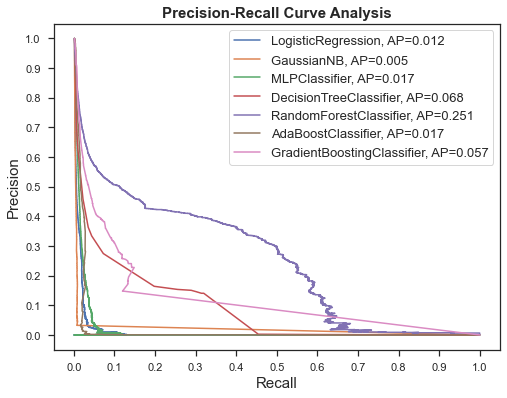

Took 54.172147274017334 seconds


In [104]:
### MAKING CHART FOR PAPER
start = time.time()

from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Instantiate the classfiers and make a list
classifiers = [logmodel, nbmodel, nnmodel, dtmodel, rfmodel, boostmodel, gboostmodel]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for model in classifiers:
    yproba = model.predict_proba(xtest)[::,1]
    
    fpr, tpr, _ = precision_recall_curve(ytest,  yproba)
    auc = average_precision_score(ytest, yproba)
    
    result_table = result_table.append({'classifiers':model.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)
# Plot the figure
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AP={:.3f}".format(i, result_table.loc[i]['auc']))
    
# plt.plot([0,1], [1,0], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Recall", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("Precision", fontsize=15)

plt.title('Precision-Recall Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='upper right')

plt.show()

print(f"Took {time.time() - start} seconds")

## WORKSPACE

In [44]:
# raw.loc[(raw['POLREF'] == 12015555)]

In [45]:
# raw[(raw['ACTIVEMAR1'] == 0.0) & (raw['INACTIVEMAR1'] == 0.0)]
# raw[raw['INACTIVEMAR1'] == 1]

In [46]:
# raw.pivot_table(values = ['CUSTREF'], index = ['SALESTYPE2'], columns = ['INACTIVEMAR1'], aggfunc = np.size)

In [47]:
# fulldatalabs.pivot_table(values = ['POLICIES'], index = ['PAYTYPE_CASH'], columns = ['INACTIVEMAR1'], aggfunc = np.size)

In [48]:
# pd.DataFrane(xtest)